# Diffusion, Diffusion+Forcing, Advection, and Diffusion+Forcing+Advection Models
## Simulated in 1D and 2D

***Shaunticlair Ruiz (based on document by Ian Fenty)***
***2024-06-24***


This notebook introduces diffusion, atmospheric forcing, and advection, in an ocean concentrate model.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import helper

-------
# 1D Spatially-Invariant Diffusion

-------

### Framing Simple 1D Diffusion

We consider $n$ bins in a row along one axis, Each bin has width $\Delta x$.

$$\begin{bmatrix}\cdot & \cdot & \cdot & \cdot & \cdot & \cdot \end{bmatrix}$$
- The total substance in a cell is given by $z_i$.

$$Z = \begin{bmatrix}z_0 & z_1 & z_2 & z_3 & z_4 & z_5 \end{bmatrix}$$

- Concentration is given by $c_i$.
$$c_i = \frac{z_i}{\Delta x} \implies C = \begin{bmatrix}c_0 & c_1 & c_2 & c_3 & c_4 & c_5 \end{bmatrix}$$
- Each pair of adjacent bins allows transfer of substance between cells. 
$$ \begin{bmatrix}c_0 & \leftrightarrow & c_1 & \leftrightarrow & c_2 & \leftrightarrow & c_3 & \leftrightarrow & c_4 & \leftrightarrow & c_5 \end{bmatrix}$$

In [3]:
n = 10
delta_x = 1

Z = np.random.rand(10)
C = Z / delta_x

### Deriving Simple 1D Diffusion

Consider cell $i$, adjacent to cells $i-1$ and $i+1$. Substance is allowed to transfer once per timestep.

$$ \begin{bmatrix}\cdots & c_{i-1} & c_{i} & c_{i+1} & \cdots\end{bmatrix}$$

First, we view the boundary between $i-1$ and $i$.

- Diffusion occurs because our substance freely drifts in all directions. At this boundary, we have some material exiting cell $i-1$ to enter $i$, and some material exiting cell $i$ to enter cell $i-1$.

- The more substance in a cell, the more particles that can drift out. 

  - If $c_{i-1}$ increases, then more substance will enter cell $i$. If $c_{t}$ increases, more substance will exit cell $i$.

  $$\begin{bmatrix}\cdots & c_{i-1} & ⇌ & c_{i} & \cdots\end{bmatrix} \qquad \qquad
  \frac{\Delta z_i^{LEFT}}{\Delta t} \propto c_{i-1} - c_i $$

- If the distance between two cells is smaller, then the gradient is stronger, and the concentration difference across our boundary is greater: we end up with more diffusion in the same time.

$$\frac{\Delta z_i^{LEFT}}{\Delta t} \propto \frac{c_{i-1} - c_i}{\Delta x} $$

- The ratio between $\Delta z_i^{LEFT}/\Delta t$ and $(c_{i-1} - c_i)/\Delta x$ is our **diffusivity constant** $K$.

$$\frac{\Delta z_i^{LEFT}}{\Delta t} \approx K \frac{c_{i-1} - c_i}{\Delta x} $$

We repeat this process with $i$ and $i+1$. 

$$\begin{bmatrix}\cdots & c_{i} & \leftarrow & c_{i+1} & \cdots\end{bmatrix} 
\qquad \qquad
\frac{\Delta z_i^{RIGHT}}{\Delta t} \approx K  \frac{c_{i+1} - c_i}{\Delta x}$$

### (Optional) Why does the concentration gradient cause diffusion?

Above, we said that a greater gradient would cause more diffusion. Why is that? Why does decreasing $\Delta x$ increase diffusion?

Suppose we take $\Delta t < < 1$: we're consider diffusion over a very small timescale.

- In this case, our substance can only move a very short distance: only the particles very, very close to the boundary can travel across.

- So, we're not considering the average concentration in cells $i-1$ and $i$: only the concentrations very close to the boundary.

Suppose the concentration exactly at the boundary is $C$, and the boundary is at spatial position $x$. We'll assume that, in our small timestep, only particles within distance $\lambda$ can cross the boundary.

- To see how much net diffusion we have, in this small timestep, we'll compare the concentrations at position $x-\lambda$ (the "left" side) and position $x+\lambda$ (the "right" side).
  - We'll use a linear approximation (first-order taylor) to compute these.
  - Note that here, we'll use subscripts to indicate spatial position, rather than the index of the cell.

$$ c_{x-\lambda} \approx C - \lambda \frac{\partial c}{\partial x} \qquad c_{x+\lambda} \approx C + \lambda \frac{\partial c}{\partial x} $$

The diffusion is proportional to:

$$\frac{\Delta z_i^{LEFT}}{\Delta t} \propto c_{x-\lambda} - c_{x+\lambda} = -2\lambda \frac{\partial c}{\partial x} 
\quad \implies \quad \frac{\Delta z_i^{LEFT}}{\Delta t} \propto -\frac{\partial c}{\partial x}$$

We can approximate $\frac{\partial c}{\partial x}$:

$$\frac{\partial c}{\partial x} \approx \frac{c_i - c_{i-1}}{\Delta x}$$

Finally, we have our result:


$$\frac{\Delta z_i^{LEFT}}{\Delta t} \propto \frac{c_{i-1}-c_i}{\Delta x}$$

In [4]:
K = 0.1
C_I = C

C_IP1 = np.concatenate((C_I[1:],[0]))  #c_{i+1} shifted over to match the indexing for i
C_IM1 = np.concatenate(([0],C_I[:-1])) #c_{i-1}

dZright_dt = K * (C_IP1 - C_I )/delta_x      # c_{i+1} - c_{i}
dZleft_dt =  K * (C_IM1 - C_I )/delta_x #c_{i-1} - c_{i}

##This model treats the edges of the map as having concentration 0, causing some substance to continuously bleed off the map

## We could fix this by modifying the above code, but we'll use a different approach instead, later on


If we combine $\Delta z^{LEFT}_i$ and $\Delta z^{RIGHT}_i$, we get the total change in cell $i$:

$$\frac{\Delta z_i}{\Delta t} \approx K \Big( \frac{c_{i-1} - c_i}{\Delta x} + \frac{c_{i+1} - c_i}{\Delta x}\Big)$$

We can divide by $\Delta x$ to get a change in concentration:

$$\frac{\Delta c_i}{\Delta t} \approx K \Big( \frac{c_{i-1} - c_i}{\Delta x} + \frac{c_{i+1} - c_i}{\Delta x}\Big) / \Delta x$$

In the discrete case, this gives us our complete model for timestepping:

$$\frac{\Delta c_i}{\Delta t} \approx K   \Big( \frac{c_{i+1} + c_{i-1} - 2c_i}{(\Delta x)^2} \Big)  $$

In [5]:
dZ_dt = dZright_dt + dZleft_dt
dC_dt = dZ_dt / delta_x

### Quick aside: continuous form, partial differential equation for Diffusion

In the continuous limit, where $\Delta t \to 0$, these terms approach an accurate derivative. First, we rearrange a bit:

$$\frac{\Delta c_i}{\Delta t} \approx K \Big(  \frac{c_{i+1} - c_i}{\Delta x} - \frac{c_{i} - c_{i-1}}{\Delta x} \Big) / \Delta x$$

We take the limit for the inner derivatives:

$$ \Big(\frac{\partial c}{\partial t}\Big)_i \approx K \Bigg(   \Big( \frac{\partial c}{\partial x} \Big)_{i+1}  - \Big( \frac{\partial c}{\partial x} \Big)_{i} \Bigg) / \Delta x $$

And we take the limit a second time.

$$ \Big(\frac{\partial c}{\partial t}\Big)_i = K \Big( \frac{\partial^2c}{\partial x^2} \Big)_{i}  $$

This is Fick's Second Law of Diffusion. Our discrete case above allows us to approximate these physics in our discrete world model.



### Forward Simulation of Simple 1D

We can use this discretization to implement our diffusion forward in time. Each timestep, we update our current concentrations:

$$ c_i(t+1) \approx c_i(t) + \frac{\partial c_i}{\partial t} \cdot \Delta t $$

This derivative is approximated by our current concentrations:

$$ c_i(t+1) \approx c_i(t) + K \Big( \frac{c_{i+1}(t) + c_{i-1}(t) - 2c_i(t)}{(\Delta x)^2} \Big) \cdot \Delta t $$

We can rearrange to reveal its linear behavior:

$$ c_i(t+1) \approx \Big( 1 - \frac{2K\Delta t}{(\Delta x)^2} \Big) c_i(t)  + 
              \Big( \frac{K\Delta t}{(\Delta x)^2}  \Big) c_{i-1}(t)  +  
              \Big( \frac{K\Delta t}{(\Delta x)^2}  \Big) c_{i+1}(t) $$
              

We have a lot of common terms. We can represent these with a single expression:

$$
\beta = \frac{K\Delta t}{(\Delta x)^2}
$$

Giving us a nicer equation:

$$ c_i(t+1) \approx \Big( 1 - 2\beta \Big) c_i(t)  + 
              \beta  c_{i-1}(t)  +  
              \beta c_{i+1}(t) $$

Thus, we can encode this model as a linear system $c(t+1) = Mc(t)$,  where we treat $c(t)$ as a column vector.


In [6]:

def make_M_1d_diffusion_simple(n: int, dt: float, K: float, dx: float):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 1D.
    c(t+1) = Mc(t)
    
    Spatial-invariant case, where diffusivity and cell size are the same everywhere.

    n  represents the number of discrete cells.
    dt represents the duration of each timestep.
    
    K  represents the diffusivity constant between cells.
    dx represents the length of each cell 
        (equivalently, the distance between the centers of each cell)
    """
    M = np.zeros((n,n))

    beta = (K * dt / dx)/dx

    for i in range(n): #Determine the weights that contribute to c_i(t+1)
        #Weight for c_i(t)
        M[i,i] = 1 - dt * 2 * beta

        #Weight for c_i(t-1)
        if i>0:
            M[i,i-1] = dt * beta
        #Weight for c_i(t+1)
        if i<n-1:
            M[i,i+1] = dt * beta

    return M

n = 1000

M = make_M_1d_diffusion_simple(n=n,dt=0.001,K=1,dx=1)

Now, we can use 

$$c(t+1) \approx Mc(t)$$

To simulate forward in time.

In [7]:
def compute_1d_linear_time_evolution(c0, M, snapshots, duration):
    """
    Computes 
    c(t+1) = Mc(t) 
    Forward in time
    In 1D
    """
    saved=[]
    c = c0

    for i in range(duration):

        if i in snapshots:
            saved.append(c)

        c = M @ c

    return saved


def disp_1d_time_evolution(data_list, snapshots):
    # Convert list of 1D arrays to 2D array
    data_2d = np.array(data_list)
    
    # Calculate global min and max for consistent color scaling
    vmin = np.min(data_2d)
    vmax = np.max(data_2d)
    
    # Create the heatmap
    fig, axes = plt.subplots(len(data_list), 1, figsize=(10, 2 * len(data_list)))
    fig.suptitle('Evolution in time', fontsize=16)
    
    for i, (data, ax) in enumerate(zip(data_list, axes)):
        im = ax.imshow(data.reshape(1, -1), aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(f'Heatmap at t={snapshots[i]}')
        ax.set_xlabel('$x$')
        ax.set_yticks([])
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()




c0 = np.random.rand(n,1)
snapshots = [0, 250, 500, 1000, 4000, 16000, 64000]
duration = max(snapshots)+10

#saved_data = compute_1d_time_evolution(c0, M, snapshots,duration)
#disp_1d_evolution(saved_data, snapshots)


-------
# 1D Spatially-Variant Diffusion

-------



### Deriving Spatially-Variant 1D diffusion

The approach we used above covers basic 1D diffusion, but there's an important feature it doesn't account for:

- Every single cell is required to have the same properties.

For modelling the earth, we need a more flexible model. Each cell will be allowed to have its own properties:

- Width of cell $i$, $\Delta X^G_i$
  - There are $n$ of these values.
- Distance of the center of cell $i$ from cell $i-1$, $\Delta X^C_i$
  - There are $n+1$ of these values.
- Diffusivity between cell $i$ and cell $i-1$ ("left" edge) $K_i$
  - There are $n+1$ of these values.





In [8]:
n = 10

DX_G = np.array([1] * n) #Cell width
DX_C = np.array([1] * (n+1)) #Distance from i-1 center to i center 
K   = np.array([0.1] * (n+1)) #Diffusivity between i-1 and i


Z = np.random.rand(10)

C = Z / DX_G #Cell density depends on cell width

Let's take our previous case:

$$\frac{\partial c_i}{\partial t} \approx \Bigg(K  \Big( \frac{c_{i-1} - c_i}{\Delta x} \Big) + K\Big(\frac{c_{i+1} - c_i}{\Delta x}\Big) \Bigg)/ \Delta x$$

And modify it:

- First term represents the boundary between $i-1$ and $c_i$: we replace those terms with $\Delta X^C_i$ and $K_i$
- Second term is the same, but we use $i+1$ instead
- The distance between the edges is given by $\Delta X^G_i$

$$\frac{\partial c_i}{\partial t} \approx \Bigg(K_i  \Big( \frac{c_{i-1} - c_i}{\Delta X^C_i} \Big) + K_{i+1}\Big(\frac{c_{i+1} - c_i}{\Delta X^C_{i+1}}\Big) \Bigg)/ \Delta X^G_i$$


In [9]:
C_I = C

C_IP1 = np.concatenate((C_I[1:],[0])) #c_{i+1} shifted over to match the indexing for i
#Similar logic as previous
C_IM1 = np.concatenate(([0],C_I[:-1])) #c_{i-1}

#We can apply across all elements at the same time
S = K / DX_C

dZleft_dt  = S[:-1] * (C_IM1 - C_I) #Remove last element: we don't care about the rightmost boundary
dZright_dt = S[1:]  * (C_IP1 - C_I) #Remove first element: we don't care about leftmost boundary  


dZ_dt = dZleft_dt + dZright_dt
dC_dt = dZ_dt / DX_G #Element-wise




### Forward Simulation of Spatially-Variant 1D

We'll plug this into 

$$ c_i(t+1) \approx c_i(t) + \frac{\partial c_i}{\partial t} \cdot \Delta t $$

And sort it by each $c$ term, so we can put it into our linear form:

$$ c_i(t+1) \approx  \Big( 1 - \frac{K_i \Delta t}{\Delta X^C_i \Delta X^G_i}  - \frac{K_{i+1} \Delta t}{\Delta X^C_{i+1}\Delta X^G_i} \Big) c_i(t) + 
               \Big( \frac{K_i \Delta t}{\Delta X^C_i \Delta X^G_i}  \Big) c_{i-1}(t)+  
               \Big( \frac{K_{i+1} \Delta t}{\Delta X^C_{i+1}\Delta X^G_i} \Big) c_{i+1}(t)$$

This equation is getting unwieldy: let's use some variables to represent common groups of variables.

$$\beta_i = \frac{\Delta t}{\Delta X^G_i} 
\qquad \qquad \qquad
S_i = \frac{K_i}{\Delta X^C_i}$$

$\beta_i$ is shared across all terms, while $S_i$ and $S_{i+1}$ both show up in the same equation:

$$
    c_i(t+1) \approx \quad  ( 1 - \beta_i S_i - \beta_i S_{i+1}) c_i(t) \quad+\quad  (\beta_i S_i) c_{i-1}(t) \quad+\quad (\beta_i S_{i+1}) c_{i+1}(t)
$$

Now, we're ready. We'll represent this system as $c(t+1) \approx Mc(t)$.

In [10]:
def make_M_1d_spatially_variant(n: int, dt: float, 
                                K: np.ndarray,  
                                DX_C: np.ndarray, DX_G:np.ndarray ):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 1D.
    c(t+1) = Mc(t)

    Spatially-variant case, where
    - the boundaries between cells can have different diffusivities
    - Each cell can have a different size
    - The distance between adjacent cell centers is variable

    n       represents the number of discrete cells.
    dt      represents the duration of each timestep.
    
    K[i]    represents the diffusivity constant between cells i-1 and i     
    DX_C[i] represents the distance between the centers of cells i-1 and i
    DX_G[i] represents the length of cell i
    """
    if K.shape != (n+1,):
        raise ValueError("K's size doesn't match n+1")
    if DX_C.shape != (n+1,):
        raise ValueError("DX_C's size doesn't match n+1")
    if DX_G.shape != (n,):
        raise ValueError("DX_G's size doesn't match n")

    M = np.zeros((n,n))

    beta = dt / DX_G   #Every term has dt/DX_G[i]                     (not shifted in time)
    S    = K/DX_C      #Every term contains some form of K[j]/DX_C[j] (shifted in time)

    # Now, we create weights for c_i, c_{i+1}, c_{i-1}
    # We'll use the form
    # c_i(t+1) = QI * c_i(t) + QIP1 * c_{i+1}(t) + QIM1 * c_{i-1}(t)

    d_IM1 = beta * S[:-1] #S[0] is never relevant as a right boundary
    d_IP1 = beta * S[1:]  #Contribution from the right
    
    d_I = 1 - d_IM1 - d_IP1 #Flow outwards due to internal concentration (-Q_IM1, -Q_IP1) 
                         #is equally easy as inward flow due to external concentration (+Q_IM1, Q_IP1) 
                         #because the same boundary is being used in either case

    

    for i in range(n): #Determine the weights that contribute to c_i(t+1)
        #Weight for c_i(t)
        M[i,i] = d_I[i]

        #Weight for c_i(t-1)
        if i>0:
            M[i,i-1] = d_IM1[i]
        #Weight for c_i(t+1)
        if i<n-1:
            M[i,i+1] = d_IP1[i]

    return M

n = 1000

M = make_M_1d_spatially_variant(n=n, dt = 0.001,
                                K =   np.array([0.1]*400 + [1]*201 + [0.1] * 400),
                                DX_C = np.array([1]*1001),
                                DX_G = np.array([1]*1000)
                                )
                                


Once again, we demonstrate our function by iterating

$$c(t+1) \approx Mc(t)$$

To simulate forward in time.

In [11]:
c0 = np.random.rand(n,1)
snapshots = [0, 250, 500, 1000, 4000, 16000, 64000]
duration = max(snapshots)+10

#saved_data = compute_1d_time_evolution(c0, M, snapshots,duration)
#disp_1d_evolution(saved_data, snapshots)

-------
# 2D Spatially-Invariant Diffusion

-------


### Framing Spatially-Invariant 2D diffusion

Now, we move on to 2D diffusion. First, we'll consider a case that's spatially invariant.
- We return to every cell having the same properties.

First, a general re-structuring:
- Our cells are stored in an $n_r \times n_c$ matrix. 
  - For example: $c_{ij}$ is in row $i$ ($y$-axis), column $j$ ($x$-axis).

New parameters:
- Each cell has $x$-axis width $\Delta X^G$
- Each cell has $y$-axis height $\Delta Y^G$
- The horizontal ($x$-axis) distance between cell centers is $\Delta X^C$
- The vertical ($y$-axis) distance between cell centers is $\Delta Y^C$
- The vertical boundary between cells has diffusivity $K^X$
- The horizontal boundary between cells has diffusivity $K^Y$

We also want to be able to model a non-flat planet: we'll need non-rectangular grid cells. This means that the area of a grid cell may not equal the area of a rectangular grid panel: $\Delta X^G\cdot \Delta Y^G$.

Instead, we manually set the area to be a new constant:
- Each cell has volume/area $A$ (written in code as $RAC$).

In [12]:
nr,nc = 7,8
DX_G = 1
DY_G = 1
DX_C = 1
DY_C = 1
K_x  = 0.1
K_y  = 0.1
RAC = 1 

Z = np.random.rand(nr,nc)
C = Z / RAC #Substance diluted by volume

### Deriving Spatially-Invariant 2D diffusion

Now, we have to re-derive our equation for $\partial c/\partial t$.

- We'll consider flow coming in from each edge of our 2D square. For example, consider the north:

$$J^{North} \approx K_y  \frac{c_{(i+1,j)} - c_{ij}}{\Delta Y^C}$$

- Something we didn't have to consider in the 1D case: this is the *flux* through the side: the substance moved, **per unit surface area**.
  - For example: flow in the $y$ direction is proportional to the horizontal length of that side ($\Delta X^G$)

$$
\frac{\Delta z_{ij}^{North}}{\Delta t} \approx  J^{North} \Delta X^G 
$$

We can apply this to each direction: north, south, east, west.

$$
\frac{\Delta z_{ij}^{North}}{\Delta t} \approx \Big(\frac{K_y \cdot \Delta X^G}{\Delta Y^C} \Big) \cdot (c_{(i+1,j)} - c_{ij})
\qquad \qquad \qquad
\frac{\Delta z_{ij}^{South}}{\Delta t} \approx \Big(\frac{K_y \cdot \Delta X^G}{\Delta Y^C} \Big) \cdot (c_{(i-1,j)} - c_{ij})
$$

$\qquad$

$$
\frac{\Delta z_{ij}^{East}}{\Delta t} \approx \Big(\frac{K_x \cdot \Delta Y^G}{\Delta X^C} \Big) \cdot (c_{(i,j+1)} - c_{ij})
\qquad \qquad \qquad
\frac{\Delta z_{ij}^{West}}{\Delta t} \approx \Big(\frac{K_x \cdot \Delta Y^G}{\Delta X^C} \Big) \cdot (c_{(i,j-1)} - c_{ij})
$$

In [13]:
C_IJ = C

C_IP1_J = np.vstack((C_IJ[1:, :], 
                    np.zeros(( 1,C_IJ.shape[1] )) 
))

C_IM1_J = np.vstack((np.zeros( (1,C_IJ.shape[1]) ),
                     C_IJ[:-1, :]
))

C_I_JP1 = np.hstack((C_IJ[:, 1:],
                    np.zeros(( C_IJ.shape[0], 1 )) 
))

C_I_JM1 = np.hstack((np.zeros(( C_IJ.shape[0], 1 )),
                    C_IJ[:, :-1],                
))

dZnorth_dt = (K_y * DX_G / DY_C) * (C_IP1_J - C_IJ)
dZsouth_dt = (K_y * DX_G / DY_C) * (C_IM1_J - C_IJ)

dZeast_dt  = (K_x * DY_G / DX_C) * (C_I_JP1 - C_IJ)
dZwest_dt  = (K_x * DY_G / DX_C) * (C_I_JM1 - C_IJ)

We gather these into a single expression, representing all flow into the cell (and using it to approximate a derivative):

$$\frac{\partial z_{ij}}{\partial t} \approx 
\Big(\frac{K_y \cdot \Delta X^G}{\Delta Y^C} \Big) \cdot (c_{(i+1,j)} + c_{(i-1,j)} - 2c_{ij}) +
\Big(\frac{K_x \cdot \Delta Y^G}{\Delta X^C} \Big) \cdot (c_{(i,j+1)} + c_{(i,j-1)} - 2c_{ij})
$$

We can turn this into a concentration by dividing by the area. If we had perfect grid cells, then we'd use $\Delta X^G \Delta Y^G$.

- But since we don't know that, we'll use the explicit area, given by $A$ (or $RAC$).

$$\frac{\partial c_{ij}}{\partial t} \approx 
\Big(\frac{K_y \cdot \Delta X^G}{A \cdot \Delta Y^C} \Big) \cdot (c_{(i+1,j)} + c_{(i-1,j)} - 2c_{ij}) +
\Big(\frac{K_x \cdot \Delta Y^G}{A \cdot \Delta X^C} \Big) \cdot (c_{(i+1,j)} + c_{(i-1,j)}  - 2c_{ij})
$$


In [14]:
dZ_dt = dZnorth_dt + dZsouth_dt + dZwest_dt + dZeast_dt
dC_dt = dZ_dt / RAC

### Model M of Spatially-Invariant 2D

Once again, we'll implement the form

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

Our equations are even larger and messier than before. Let's re-introduce $\beta$ and $S$. To accommodate our extra dimension, we'll need a $T$ term, too.

$$
\beta = \frac{\Delta t}{A}
\qquad \qquad \qquad
S = \frac{K_x \cdot\Delta Y^G}{\Delta X^C}
\qquad \qquad \qquad
T = \frac{K_y \cdot\Delta X^G}{\Delta Y^C}
$$

Now, let's sort things into a linear form:

$$
\begin{align*}
c_{ij}(t+1) \approx & \Big( 1 - 2\beta T -2 \beta S \Big)\cdot c_{ij}(t) \\
&+  
\Big( \beta T \Big) \cdot c_{(i+1,j)}(t) + \Big( \beta T \Big) \cdot c_{(i-1,j)}(t) \\
&+
\Big( \beta S \Big) \cdot c_{(i,j+1)}(t) + \Big( \beta S \Big) \cdot c_{(i,j-1)}(t) 
\end{align*}
$$




### Mapping 2D diffusion model onto 1D vector

Another detail we didn't have to worry about in 1D:

- $c_{i,j}$ has *two indices*: we have to decide how to map that into a vector $c(t)$.

Our approach is simple:

- We start counting, starting from the top left at $(0,0)$.
- We start moving right (incrementing $j$), until we reach the edge. Then, we move to the start of the second row.

For example, if we had a $(2,3)$ array $c$, we would sort the indices as:

$$u_{indices} = \begin{bmatrix} (0,0) & (0,1) & (0,2) & (1,0) & (1,1) & (1,2)\end{bmatrix}^\top$$

Equivalently:

$$c_{indices} = \begin{bmatrix} 0 & 1 & 2 \\ 3 & 4 & 5\end{bmatrix}$$

Now, we've transformed our $(n_r, n_c)$ array $c$ into a length-$(n_r\cdot n_c)$ vector $u$, where $u_{n_ci+j} = c_{i,j}$. 

We'll save $c_{indices}$ to figure out where to put each weight in $M$.

### Simulation of Spatially-Invariant 2D

Finally, we can compute $c(t)$ for our simulation:

$c(t+1) \approx Mc(t)$

In [15]:
def make_M_2d_diffusion_spatially_invariant(nr: int, nc: int, dt: float,
                                K_x: float, K_y: float,
                                DX_C: float, DY_C: float,
                                DX_G: float, DY_G: float,
                                RAC: float):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-invariant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep
    
    K_x:    the diffusivity constant along the x-axis (between columns)
    K_y:    the diffusivity constant along the y-axis (between rows)
    DX_C:   the horizontal distance (x-axis) between the centers cells in adjacent columns
    DY_C:   the vertical distance (y-axis) between the centers of cells in adjacent rows
    DX_G:   the horizontal length (x-axis) of a cell.
    DY_G:   the vertical length of a cell.

    RAC:    the area of a cell.
    """

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    S = K_x*DY_G/DX_C
    T = K_y*DX_G/DY_C

    # Weights for each element
    
    d_IP1_J = beta * T
    d_IM1_J = beta * T
    d_I_JP1 = beta * S
    d_I_JM1 = beta * S

    d_IJ = 1 - 2 * beta * T - 2 * beta * S

    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = d_IJ
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = d_I_JM1
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = d_I_JP1
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = d_IP1_J
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = d_IM1_J
    
    return M

nr,nc = 40,50            

M = make_M_2d_diffusion_spatially_invariant(nr = nr, nc = nc, dt = 0.01,
                                  K_x = .1, K_y = 0.01,
                                  DX_C = 1 , DY_C = 1,
                                  DX_G = 1, DY_G = 1,
                                  RAC = 1)


We can simulate our model forward in time, and plot it.

$$c(t+1) \approx Mc(t)$$

In [16]:
def compute_2d_linear_time_evolution(c0, M, snapshots, duration):
    """
    Computes 
    c(t+1) = Mc(t) 
    Forward in time, in 2D
    """
    saved=[]
    c = c0

    for i in range(duration):

        if i%10 == 0:
                print(i)

        if i in snapshots:
            saved.append(c)

        c = M @ c

    return saved


def disp_2d_time_evolution(data_list, snapshots, nr, nc, vmin = None, vmax = None):
    # Reconstruct 1D arrays into 2D arrays
    data_2d_list = [data.reshape(nr, nc) for data in data_list]
    
    # Calculate global min and max for consistent color scaling
    if not vmin:
        vmin = min(np.min(data) for data in data_2d_list)
    if not vmax:
        vmax = max(np.max(data) for data in data_2d_list)
    
    # Create the heatmaps
    fig, axes = plt.subplots(len(data_list), 1, figsize=(10, 5 * len(data_list)))
    fig.suptitle('Evolution in time', fontsize=16)
    
    if len(data_list) == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, (data, ax) in enumerate(zip(data_2d_list, axes)):
        im = ax.imshow(data, aspect='equal', cmap='coolwarm', vmin=vmin, vmax=vmax, origin='lower')
        ax.set_title(f'Heatmap at t={snapshots[i]}')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()




c0 = np.random.rand(nr*nc,1)
snapshots = [0, 250, 500, 1000, 4000, 16000, 64000]
duration = 16010

#saved_data = compute_2d_linear_sim(c0, M, snapshots,duration)
#disp_2d_evolution(saved_data, snapshots, nr, nc)


-------
# 2D Spatially-Variant Diffusion

-------

### Framing Spatially-Variant 2D diffusion

Now, we want to enable each cell and cell boundary to have its own properties: we'll use north, south, east, and west to describe directions.

Cell dimensions: a cell can have different lengths on each of its four sides.

- The length of the "south" side of cell $(i,j)$ is $\Delta X^G_{ij}$.
  - Equivalently, this the the "north" side of cell $(i-1,j)$.
  - Matrix $\Delta X^G$ has shape $(nr+1, nc)$.
- The length of the "west" side of cell $(i,j)$ is $\Delta Y^G_{ij}$.
  - Equivalently, this the the "east" side of cell $(i,j-1)$
  - Matrix $\Delta Y^G$ has shape $(nr, nc+1)$.

Cell center distance:
- The horizontal (east-west) distance between the centers of cells $(i,j-1)$ and $(i,j)$ is $\Delta X C_{ij}$
  - Matrix $\Delta X^C$ has shape $(nr, nc + 1)$.
- The vertical (north-south) distance between the centers of cells $(i-1,j)$ and $(i,j)$ is $\Delta Y C_{ij}$
  - Matrix $\Delta Y^C$ has shape $(nr + 1, nc)$.

Diffusivity constants:
- The east-west boundary between cells $(i,j-1)$ and $(i,j)$ has diffusivity $K^X_{ij}$
  - Matrix $K^X$ has shape $(nr, nc + 1)$.
- The north-south boundary between cells $(i-1,j)$ and $(i,j)$ has diffusivity $K^Y_{ij}$
  - Matrix $K^Y$ has shape $(nr + 1, nc)$.

Cell area:
- Cell $(i,j)$ has area $A_{ij}$ (to match MITGCM notation, we'll write this as RAC in code)
  - Matrix $A$ has shape $(nr, nc)$.
  - This may not be equal to the area of a grid panel, $\Delta X^G_{ij}\cdot \Delta Y^G_{ij}$


In [17]:
nr,nc = 7,8
DX_G =  1 *   np.ones((nr+1, nc))
DY_G =  1 *   np.ones((nr,   nc+1))
DX_C =  1 *   np.ones((nr,   nc+1))
DY_C =  1 *   np.ones((nr+1, nc))
KX  =  0.1 * np.ones((nr,   nc+1))
KY  =  0.1 * np.ones((nr+1, nc))
RAC  =  1  *  np.ones((nr,   nc))

Z = np.random.rand(nr,nc)
C = Z / RAC #Substance diluted by volume

### Additional Framing Details

An important clarification about $\Delta X^C$, $\Delta Y^C$, $\Delta X^G$, $\Delta Y^G$, $K_x$, $K_y$:

- Above, we describe the $(i,j)$ index as refering to the boundary to the south/west of our cell. Then, why are there $nr+1$ or $nc+1$ boundaries?
- This is so we can have the boundary north/east of our northernmost/easternmost cells. These are "south" or "west" to some imaginary $nr+1$ row, or $nc+1$ column.

We'll also introduce one more feature: making our map periodic.

- Rather than just having a flat map, we'll allow our map to "loop around": connecting east/west edges, or north/south edges.
  - This will allow us to model a globe, by connecting east/west (and setting $K^Y_{ij}=0$ on the northernmost and southernmost edges!)

### Deriving Spatially-variant 2D diffusion

We start with our spatially-invariant 2D equations, and add indexing: 

- The north and west directions use the $i^{th}$ boundary, while south and east use the $(i+1)^{th}$ boundary.

$$
\frac{\Delta c_{ij}^{North}}{\Delta t} \approx \Big(\frac{K^Y_{(i+1,j)} \cdot \Delta X^G_{(i+1,j)}}{A_{ij} \cdot \Delta Y^C_{(i+1,j)}} \Big) \cdot (c_{(i+1,j)} - c_{ij})
\qquad \qquad \qquad
\frac{\Delta c_{ij}^{South}}{\Delta t} \approx \Big(\frac{K^Y_{ij} \cdot \Delta X^G_{ij}}{A_{ij} \cdot \Delta Y^C_{ij}} \Big) \cdot (c_{(i-1,j)} - c_{ij})
$$

$\qquad$

$$
\frac{\Delta c_{ij}^{East}}{\Delta t} \approx \Big(\frac{K^X_{(i,j+1)} \cdot \Delta Y^G_{(i,j+1)}}{A_{ij} \cdot \Delta X^C_{(i,j+1)}} \Big) \cdot (c_{(i,j+1)} - c_{ij})
\qquad \qquad \qquad
\frac{\Delta c_{ij}^{West}}{\Delta t} \approx \Big(\frac{K^X_{ij} \cdot \Delta Y^G_{ij}}{A_{ij} \cdot \Delta X^C_{ij}} \Big) \cdot (c_{(i,j-1)} - c_{ij})
$$

We'll need to group these, to clean things up:

$$S_{ij} = \frac{K^X_{ij} \cdot \Delta Y^G_{ij} }{\Delta X^C_{ij} } \qquad \qquad T_{ij} = \frac{K^Y_{ij} \cdot \Delta X^G_{ij} }{\Delta Y^C_{ij} }$$

In [18]:
C_IJ = C

C_IP1_J = np.vstack((C_IJ[1:, :], 
                    np.zeros(( 1,C_IJ.shape[1] )) 
))

C_IM1_J = np.vstack((np.zeros( (1,C_IJ.shape[1]) ),
                     C_IJ[:-1, :]
))

C_I_JP1 = np.hstack((C_IJ[:, 1:],
                    np.zeros(( C_IJ.shape[0], 1 )) 
))

C_I_JM1 = np.hstack((np.zeros(( C_IJ.shape[0], 1 )),
                    C_IJ[:, :-1],                
))

S = KX * DY_G / DX_C
T = KY * DX_G / DY_C

T_IJ    = T[:-1, :]
T_IP1_J = T[1:,  :]

S_IJ    = S[:, :-1]
S_I_JP1 = S[:, 1:]




dCnorth_dt = (T_IP1_J/RAC) * (C_IP1_J - C_IJ)
dCsouth_dt = (T_IJ/RAC) * (C_IM1_J - C_IJ)

dCwest_dt  = (S_I_JP1/RAC) * (C_I_JM1 - C_IJ)
dCeast_dt  = (S_IJ/RAC) * (C_I_JP1 - C_IJ)

We want combine all of these into a single equation:

$$ \frac{\partial c_{ij}}{\partial t} \approx 
\frac{T_{(i+1,j)}}{A_{ij}}(c_{(i+1,j)} - c_{ij}) + \frac{T_{ij}}{A_{ij}}(c_{(i-1,j)} - c_{ij}) + 
\frac{S_{(i,j+1)}}{A_{ij}}(c_{(i,j+1)} - c_{ij}) + \frac{S_{ij}}{A_{ij}}(c_{(i,j-1)} - c_{ij})$$

We want to plug this into:

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

We'll re-introduce our substitution term $\beta_{ij}$ to clean things up:

$$\beta_{ij} = \frac{\Delta t}{A_{ij}}$$

We get our completed equation:


$$\begin{align*} 
c_{ij}(t+1) \approx & 
\Big( 1 - \beta_{ij}(T_{(i+1,j)}  + T_{ij}  + S_{(i,j+1)} + S_{ij}) \Big) \cdot c_{ij}(t) \\
&+\Big( T_{(i+1,j)}\beta_{ij} \Big) c_{(i+1,j)} +\Big( T_{ij}\beta_{ij} \Big)   \cdot c_{(i-1,j)}(t) \\
& +\Big( S_{(i,j+1)}\beta_{ij} \Big) c_{(i,j+1)}+\Big( S_{ij}\beta_{ij} \Big)  \cdot c_{(i,j-1)}(t) \end{align*}$$

In [19]:
dC_dt = dCnorth_dt + dCsouth_dt + dCwest_dt + dCeast_dt

### Simulation of Spatially-Variant 2D Diffusion

Finally, we can compute $c(t)$ for our simulation:

$c(t+1) \approx Mc(t)$

In [20]:
# nr: number of tracer rows 
# nc: number of tracer columns
# dt: time step

# KX: diffusivity matrix in x direction.  dimension is nr x nc+1
#     defined on 'west' and 'east' edges of all cells
#     [0,0] index is the diffusivity across the 'west' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'east' side of the northeasternmost grid cell

# KX: diffusivity matrix in y direction.  dimension is nr+1 x nc
#     defined on 'north' and 'south' edges of all cells
#     [0,0] index is the diffusivity across the 'south' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'north' side of the northeasternmost grid cell

# DXC: distance between adjacent grid cell centers in x-direction. dimension is nr x nc+1
#     defined through 'west' and 'east' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its west
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its east

# DYC: distance between adjacent grid cell centers in y-direction. dimension is nr+1 x nc
#     defined through 'north' and 'south' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its south
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its north

# DXG: length of the 'south/north' sides of grid cells. dimension nr+1 x nc
#     [0,0] index is the length of the 'south' side of southwesternmost cell
#     [-1,-1] index is the length of the 'north' side of northeasternmost cell

# DYG: length of the 'west/east' sides of grid cells. dimension is nr x nc+1
#     [0,0] index is the length of the 'west' side of southwesternmost cell
#     [-1,-1] index is the length of the 'east' side of northeasternmost cell

# i is row
# j is column

# M[i,j] => ith row, jth column


def make_M_2d_diffusion_spatially_variant(nr: int, nc: int, dt: float,
                                KX: np.ndarray, KY: np.ndarray,
                                DX_C: np.ndarray, DY_C: np.ndarray,
                                DX_G: np.ndarray, DY_G: np.ndarray,
                                RAC: np.ndarray,
                                cyclic_east_west:   bool = True, 
                                cyclic_north_south: bool = False):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-variant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep

    (i,j) = (0,  0) is the southwesternmost cell
    (i,j) = (-1,-1) is the northeasternmost cell

    For the below definitions:

    KX:     the diffusivity constant matrix along the x-axis (between columns)
                KX[i,j]   gives diffusivity along the "west" side of cell [i,j]  

    KY:     the diffusivity constant matrix along the y-axis (between rows)
                KY[i,j]   gives diffusivity along the "south" side of cell [i,j]  

    DX_C:   the horizontal distance (x-axis) matrix between the centers cells in adjacent columns
                DX_C[i,j] gives the distance between the centers of cells [i,j-1] and [i,j]

    DY_C:   the vertical distance (y-axis) matrix between the centers of cells in adjacent rows
                DY_C[i,j] gives the distance between the centers of cells [i-1,j] and [i,j]

    DX_G:   the horizontal length (x-axis) matrix of a cell along one edge.
                DX_G[i,j] gives the length of the "south" side of cell [i,j]  

    DY_G:   the vertical length (y-axis) matrix of a cell along one edge.
                DY_G[i,j] gives the length of the "west" side of cell [i,j]  

    RAC:    the area of a cell.
                RAC[i,j]  gives the area of cell [i,j]

    cyclic_east_west:   if True, cell [i, 0] is east of cell [i,-1]

    cyclic_north_south: if True, cell [0, j] is north of cell [-1,j]
    """

    if KX.shape !=   (nr, nc+1):
        raise ValueError("KX doesn't have the right shape for your dimensions!")
    if KY.shape !=   (nr+1, nc):
        raise ValueError("KY doesn't have the right shape for your dimensions!")
    if DX_C.shape != (nr, nc+1):
        raise ValueError("DX_C doesn't have the right shape for your dimensions!")
    if DY_C.shape != (nr+1, nc):
        raise ValueError("DY_C doesn't have the right shape for your dimensions!")
    if DX_G.shape != (nr+1, nc):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if DY_G.shape != (nr, nc+1):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    S = KX*DY_G/DX_C
    T = KY*DX_G/DY_C

    S_IJ, T_IJ     = S[:,   :-1], T[:-1,  :]
    S_IJP1, T_IP1J = S[:,   1:],  T[1:,  :]

    # Weights for each element

    d_IP1_J = beta * T_IP1J
    d_IM1_J = beta * T_IJ
    d_I_JP1 = beta * S_IJP1
    d_I_JM1 = beta * S_IJ 

    d_IJ = 1 - d_IP1_J - d_IM1_J - d_I_JP1 - d_I_JM1

    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]
            elif cyclic_north_south:
                ind_S = c_indices[-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]
            elif cyclic_north_south:
                ind_N = c_indices[0, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            elif cyclic_east_west:
                ind_W = c_indices[i, -1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
            elif cyclic_east_west:
                ind_E = c_indices[i, 0]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = d_IJ[i,j]
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = d_I_JM1[i,j]
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = d_I_JP1[i,j]
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = d_IP1_J[i,j]
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = d_IM1_J[i,j]
    
    return M

nr,nc = 128,128        

#KX   = .1 * np.ones((nr,nc+1))
#KY   = .1 * np.ones((nr+1,nc))

DX_C = .1 * np.ones((nr,nc+1))
DY_C = .1 * np.ones((nr+1,nc))

DX_G = .1 * np.ones((nr+1,nc))
DY_G = .1 * np.ones((nr,nc+1))

RAC  = .1 * np.ones((nr,nc))



For fun, we'll use the NASA logo to generate our K terms, which will show up in our diffusion plot:

In [21]:

matrix = np.where(helper.NASA_map == 0, 1, 0)

KX = np.hstack((matrix, np.zeros((matrix.shape[0],1), dtype=matrix.dtype)))
KY = np.vstack((np.zeros((1, matrix.shape[1]), dtype=matrix.dtype), matrix))

print(KX.shape, KY.shape)

def set_top_bottom_edges_to_zero(matrix):
    result = matrix.copy()

    result[0, :] = 0
    result[-1, :] = 0
    
    return result

KX, KY = set_top_bottom_edges_to_zero(KX), set_top_bottom_edges_to_zero(KY)

M = make_M_2d_diffusion_spatially_variant(nr = nr, nc = nc, dt = 0.01,
                                  KX = KX, KY = KY,
                                  DX_C = DX_C , DY_C = DY_C,
                                  DX_G = DX_G,  DY_G = DY_G,
                                  RAC = RAC)


(128, 129) (129, 128)


And finally, we generate those plots:

In [22]:
c0 = np.random.rand(nr,nc)

def add_random_circles(matrix, num_circles, radius, values):
    nr, nc = matrix.shape
    for _ in range(num_circles):
        center_r = np.random.randint(0, nr)
        center_c = np.random.randint(0, nc)
        r, c = np.ogrid[:nr, :nc]
        mask = ((r - center_r)**2 + (c - center_c)**2 <= radius**2)

        value = np.random.choice(values)
        matrix[mask] = value
    return matrix

c0 = add_random_circles(c0, 1000, 5, [-10,10])
c0 = c0.reshape(nr*nc,1)

index = lambda x,y: y*nc + x

snapshots = [0, 50, 100, 200,1000]
duration = 1001

#saved_data = compute_2d_diffusion_time_evolution(c0, M, snapshots,duration)
#disp_2d_evolution(saved_data, snapshots, nr, nc)

-------
# 2D Spatially-Variant Forcing + Spatially-Variant Diffusion
-------

### Framing 2D Spatially-Variant Forcing 

Now, we introduce some external **forcing**: in an atmospheric model, this could represent the heat from the atmosphere. 

The transfer between the atmosphere and the ocean is assumed to be proportional to the difference between their concentrations.

- Notably, we assume the atmosphere is *fixed*: the forcing concentration doesn't change, regardless of the ocean state.

We'll represent the atmospheric concentration at cell $(i,j)$ as $f_{ij}$.

- As mentioned, the change in $c_{(ij)}$ is proportional to the difference from $f_{ij}$: it's a sort of "first-order damping".

Our equation for concentration change, *only* due to the atmosphere, can be written as

$$ \frac{\partial c^{force}_{ij}}{\partial t} \propto (f_{ij} - c_{ij}) $$

We'll represent the rate of damping with a constant $F$.

$$ \frac{\partial c^{force}_{ij}}{\partial t} = F (f_{ij} - c_{ij}) $$

If we integrate this into our diffusion PDE, we get:

$$ \frac{\partial c_{ij}}{\partial t} = \frac{\partial^2 c_{ij}}{\partial x^2} + F (f_{ij} - c_{ij}) $$

### Integrating 2D Spatially-Variant Forcing and Diffusion

Introducing this to our pre-existing model is as easy as adding it to the end of our equation:

$$\begin{align*} 
c(t+1) \approx M c(t) +F (f - c(t))
\end{align*}$$

We can integrate this term into our equation:

$$\begin{align*} 
c_{ij}(t+1) \approx & \Big( 1 - \beta_{ij}(T_{(i+1,j)}  + T_{ij}  + S_{(i,j+1)} + S_{ij}) - F \Big) \cdot c_{ij}(t) \\
&+\Big( T_{(i+1,j)}\beta_{ij} \Big) c_{(i+1,j)} +\Big( T_{ij}\beta_{ij} \Big) \cdot   c_{(i-1,j)}(t) \\
&+\Big( S_{(i,j+1)}\beta_{ij} \Big) c_{(i,j+1)}+\Big( S_{ij}\beta_{ij} \Big) \cdot  c_{(i,j-1)}(t) \\
&+F f_{ij}
\end{align*}$$

But now, our equation isn't linear anymore! It's **affine**: we add a constant term $Ff$ on the end.

$$c(t+1) \approx M_f c(t) + Ff $$



### Simulation of 2D Diffusion + Forcing

In [23]:
# nr: number of tracer rows 
# nc: number of tracer columns
# dt: time step

# KX: diffusivity matrix in x direction.  dimension is nr x nc+1
#     defined on 'west' and 'east' edges of all cells
#     [0,0] index is the diffusivity across the 'west' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'east' side of the northeasternmost grid cell

# KY: diffusivity matrix in y direction.  dimension is nr+1 x nc
#     defined on 'north' and 'south' edges of all cells
#     [0,0] index is the diffusivity across the 'south' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'north' side of the northeasternmost grid cell

# DXC: distance between adjacent grid cell centers in x-direction. dimension is nr x nc+1
#     defined through 'west' and 'east' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its west
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its east

# DYC: distance between adjacent grid cell centers in y-direction. dimension is nr+1 x nc
#     defined through 'north' and 'south' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its south
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its north

# DXG: length of the 'south/north' sides of grid cells. dimension nr+1 x nc
#     [0,0] index is the length of the 'south' side of southwesternmost cell
#     [-1,-1] index is the length of the 'north' side of northeasternmost cell

# DYG: length of the 'west/east' sides of grid cells. dimension is nr x nc+1
#     [0,0] index is the length of the 'west' side of southwesternmost cell
#     [-1,-1] index is the length of the 'east' side of northeasternmost cell

# i is row
# j is column

# M[i,j] => ith row, jth column


def make_M_2d_spatially_variant_forced(nr: int, nc: int, dt: float,
                                KX: np.ndarray, KY: np.ndarray,
                                DX_C: np.ndarray, DY_C: np.ndarray,
                                DX_G: np.ndarray, DY_G: np.ndarray,
                                RAC: np.ndarray,
                                F : float,
                                cyclic_east_west:   bool = True, 
                                cyclic_north_south: bool = False):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-variant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep

    (i,j) = (0,  0) is the southwesternmost cell
    (i,j) = (-1,-1) is the northeasternmost cell

    For the below definitions:

    KX:     the diffusivity constant matrix along the x-axis (between columns)
                KX[i,j]   gives diffusivity along the "west" side of cell [i,j]  

    KY:     the diffusivity constant matrix along the y-axis (between rows)
                KY[i,j]   gives diffusivity along the "south" side of cell [i,j]  

    DX_C:   the horizontal distance (x-axis) matrix between the centers cells in adjacent columns
                DX_C[i,j] gives the distance between the centers of cells [i,j-1] and [i,j]

    DY_C:   the vertical distance (y-axis) matrix between the centers of cells in adjacent rows
                DY_C[i,j] gives the distance between the centers of cells [i-1,j] and [i,j]

    DX_G:   the horizontal length (x-axis) matrix of a cell along one edge.
                DX_G[i,j] gives the length of the "south" side of cell [i,j]  

    DY_G:   the vertical length (y-axis) matrix of a cell along one edge.
                DY_G[i,j] gives the length of the "west" side of cell [i,j]  

    RAC:    the area of a cell.
                RAC[i,j]  gives the area of cell [i,j]
    
    F:     the forcing term constant. This is the same for all cells.

    cyclic_east_west:   if True, cell [i, 0] is east of cell [i,-1]

    cyclic_north_south: if True, cell [0, j] is north of cell [-1,j]
    """

    if KX.shape !=   (nr, nc+1):
        raise ValueError("KX doesn't have the right shape for your dimensions!")
    if KY.shape !=   (nr+1, nc):
        raise ValueError("KY doesn't have the right shape for your dimensions!")
    if DX_C.shape != (nr, nc+1):
        raise ValueError("DX_C doesn't have the right shape for your dimensions!")
    if DY_C.shape != (nr+1, nc):
        raise ValueError("DY_C doesn't have the right shape for your dimensions!")
    if DX_G.shape != (nr+1, nc):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if DY_G.shape != (nr, nc+1):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    S = KX*DY_G/DX_C
    T = KY*DX_G/DY_C

    S_IJ, T_IJ     = S[:,   :-1], T[:-1,  :]
    S_IJP1, T_IP1J = S[:,   1:],  T[1:,  :]

    # Weights for each element

    d_IP1_J = beta * T_IP1J
    d_IM1_J = beta * T_IJ
    d_I_JP1 = beta * S_IJP1
    d_I_JM1 = beta * S_IJ 

    d_IJ = 1 - d_IP1_J - d_IM1_J - d_I_JP1 - d_I_JM1 - F #Only difference from previous function

    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]
            elif cyclic_north_south:
                ind_S = c_indices[-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]
            elif cyclic_north_south:
                ind_N = c_indices[0, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            elif cyclic_east_west:
                ind_W = c_indices[i, -1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
            elif cyclic_east_west:
                ind_E = c_indices[i, 0]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = d_IJ[i,j]
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = d_I_JM1[i,j]
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = d_I_JP1[i,j]
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = d_IP1_J[i,j]
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = d_IM1_J[i,j]
    
    return M



In [24]:
nr,nc = 128,128        

KX   = 2 * np.ones((nr,nc+1))
KY   = 2 * np.ones((nr+1,nc))

DX_C = .1 * np.ones((nr,nc+1))
DY_C = .1 * np.ones((nr+1,nc))

DX_G = .1 * np.ones((nr+1,nc))
DY_G = .1 * np.ones((nr,nc+1))

RAC  = .1 * np.ones((nr,nc))
F    = .02

def set_top_bottom_edges_to_zero(matrix):
    result = matrix.copy()

    result[0, :] = 0
    result[-1, :] = 0
    
    return result

KX, KY = set_top_bottom_edges_to_zero(KX), set_top_bottom_edges_to_zero(KY)

M = make_M_2d_spatially_variant_forced(nr = nr, nc = nc, dt = 0.01,
                                  KX = KX, KY = KY,
                                  DX_C = DX_C , DY_C = DY_C,
                                  DX_G = DX_G,  DY_G = DY_G,
                                  RAC = RAC, F = F)


f = np.where(helper.NASA_map == 0, 0, 1)

We'll need some new code to simulate this:

In [25]:
def compute_2d_affine_time_evolution(
        c0, M, r, snapshots, duration):
    """
    Computes 
    c(t+1) = Mc(t) + r
    Forward in time in 2D
    """
    saved=[]
    c = c0

    for i in range(duration):
        #print(i,"help")
        if i%10 == 0:
            print(i)

        if i in snapshots:
            saved.append(c)

            

        c = M @ c + r

        #print(np.max(c))

    return saved



In [26]:
c0 = np.random.rand(nr*nc,1)
snapshots = [0, 5, 10, 25, 50, 100, 250, 500, 1000, 4000, 16000, 64000]
duration = 101

#Convert F to an array (n,1) instead of (n,)
    #Not doing this causes it to run wayyy slower
const = F * f.reshape(nr*nc,1)
#print(const.shape, c0.shape)
#saved_data = compute_2d_diffusion_forcing_time_evolution(
#    c0, M, const, snapshots,duration)

#disp_2d_evolution(saved_data, snapshots, nr, nc)

-------
# 1D Spatially-Variant Advection

-------

### Framing 1D Spatially-Variant Advection

For this section, we'll ignore diffusion: we can bring it back later. 

Instead of having substance passively drift from high concentration to low concentration, we'll *actively* move it from one cell to another.

- We could model this as salty water, flowing from one cell to another (where the salt itself is our "substance" of interest)

- Transferring substance in this way is known as **advection**.

As before, each cell has a substance $z_i$, where concentration is $c_i$. But this time, we will have "flow" from one cell to another, at velocity $v_i$.

- The velocity on the boundary between cells $i-1$ and $i$ is given by $v_i$.
  - In other words, $v_i$ represents the velocity on the left boundary of cell $i$.
  - There are $n+1$ of these values.

In [27]:
n = 10

dx = 1
Z = np.random.rand(10)

v = np.array([1]*(n+1))

C = Z / dx

### Deriving 1D Spatially-Variant Advection

Let's start with the boundary between $i-1$ and $i$.

- Advection is different from diffusion: in diffusion, material is flowing in both directions, because our substance is passively drifting.
- In advection, all of the material is moving in the same direction, according to the flow of the "water".

$$\begin{bmatrix}\cdots & c_{i-1} & \to & c_{i} & \cdots\end{bmatrix} $$

Let's select a small timestep $\Delta t$. Suppose we have some velocity $v_i$. How much material $\Delta z$ is moving during that timestep?

We'll start with the left side.


### $v_i \geq 0$ case

In advection, it matters whether our water is flowing left or right.

If $v_i>0$, then our "fluid" is flowing right, entering cell $i$ from cell $i-1$. How much $z$ are we moving?

- We're moving a small block of "water". The substance $z$ in that block of water is the volume $V\llap{--\;}$ of that water, times the concentration $c$ of that unit.

$$\Delta z^{LEFT}_i \approx V\llap{--\;} c$$

- When water is flowing, the volume that is moved in time $\Delta t$ is cross-section area $\alpha_i$ times velocity $v_i$, times $\Delta t$. Let's assume $\alpha_i=1$, for our 1D case.

$$V\llap{--\;} \approx \alpha_i v_i \Delta t = v_i \Delta t$$

- What's the concentration of this water? Well, the concentration on the left side (where the water is coming from) is $c_{i-1}$.

Combining all of this, we find:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx v_ic_{i-1}$$



### $v_i<0$ case

What if $v_i<0$? Instead, substance is leaving the left side: 

- The fact that it's leaving is captured by the negative sign in $v_i$.

- Because it's leaving cell $i$, rather than $c_{i-1}$, we'll need a different concentration:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx v_ic_{i}$$

So, we have two cases:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx 
\begin{cases} 
    v_ic_{i-1} & v_i \geq 0 \\
    v_ic_i     & v_i < 0
\end{cases}$$

When we're writing code, it might be easier to instead use a different form: let's use the $\operatorname{min}$ and $\operatorname{max}$ functions.

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx 
\max(v_i,0)c_{i-1} + \min(v_i,0)c_i$$

The "max" case is only relevant if $v_i$ is positive, and the "min" case is only relevant if $v_i$ is negative.


If we repeat this process for the right side, we get a similar function:

$$\frac{\Delta z^{RIGHT}_i}{\Delta t} \approx 
-\max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1}$$

In [28]:
C_I = C

C_IP1 = np.roll(C, -1) #Roll the array so index=0 accesses the last element
C_IM1 = np.roll(C, 1)  #Roll the array so index=-1 accesses the first element

V_I = v[:-1]

#Roll the array to the left by 1
V_IP1 = v[1:]

dZleft_dt  =  np.max(V_I, 0)   * C_IM1 + np.min(V_I, 0) * C_I 
dZright_dt = -np.max(V_IP1, 0) * C_I   - np.min(V_IP1, 0) * C_IP1

If we combine $\Delta z^{LEFT}_i$ and $\Delta z^{RIGHT}_i$, we get the total change in cell $i$:

$$\frac{\Delta z_i}{\Delta t} \approx  \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} $$

We can divide by $\Delta x$ to get a change in concentration:

$$\frac{\Delta c_i}{\Delta t} \approx\Big( \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} \Big) / \Delta x $$

In [29]:
dZ_dt = dZleft_dt + dZright_dt
dC_dt = dZ_dt / dx

### Quick aside: continuous form, partial differential equation for Advection

We can take a continuous limit $\Delta t \to 0$, to get an accurate derivative. There's just one more thing we need to take care of first:

- We assume that our flow is *incompressible*, or *conservative*: we have a constant amount of "water" in each cell. What goes in, must come out.

- In our case, the volume that goes in or out during time $\Delta t$ is $v_i \alpha_i \Delta t$ on the left, and $v_{i+1} \alpha_{i+1} \Delta t$ on the right.
  - We have already assumed that every cell has $\alpha_i=1$.

$$v_i \Delta t = v_{i+1} \Delta t \implies v_i = v_{i+1}$$

If we apply this to our equation, it simplifies a bit:

$$\frac{\Delta c_i}{\Delta t} \approx  \max(v_i,0) \Big( \frac{c_{i-1} - c_{i}}{\Delta x} \Big) + \min(v_i,0) \Big( \frac{c_{i} - c_{i+1}}{\Delta x} \Big)  $$

We replace the appropriate terms with derivatives:

$$\frac{\partial c_i}{\partial t}  \approx  -\max(v_i,0) \frac{\partial c_i}{\partial x} - \min(v_i,0) \frac{\partial c_i}{\partial x}  $$

One of these terms always vanishes: either $v_i \geq 0$, or $v_i <0$. In either case, we can simplify:

$$\frac{\partial c_i}{\partial t} = -v_i \Big( \frac{\partial c_i}{\partial x} \Big) $$

This is the advective component of the equation for the advective-diffusive model. We'll come back to this.

### Forward Simulation of Advective 1D

We'll use our discretization to implement advection in time. Each timestep, we update our current concentrations:

$$c_i(t+1) \approx c_i(t) + \frac{\partial c_i}{\partial t} \Delta t$$

This derivative is approximated by our current concentrations:

$$c_i(t+1) \approx c_i(t) + \Big( \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} \Big) \frac{\Delta t}{\Delta x} $$



We'll substitute in $\beta$, the same trick we've used before: 

$$\beta = \frac{\Delta t}{\Delta x}$$

And we rearrange to get a linear(?) model:

$$c_i(t+1) \approx \Big( 1 + \beta \min(v_i,0) - \beta\max(v_{i+1},0)\Big) c_i(t) + \beta \max(v_i,0) c_{i-1}(t) - \beta\min(v_{i+1},0) c_{i+1}(t)    $$

Thus, we encode the model as a linear system $c(t+1) \approx Mc(t)$, where $c(t)$ is a column vector.

In [30]:
def make_M_1d_advection(n: int, dt: float, dx: float,
                        v: np.ndarray,
                        cyclic: bool = True):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of advection in 1D.

    c(t+1) = Mc(t)

    n:      the number of discrete cells.
    dt:     duration of a timestep
    dx:     the distance between the centers of cells in adjacent columns
    v:      the velocity constant matrix along the x-axis (between columns)
                v[i] gives the velocity at the boundary between cells i-1 and i

    cyclic: if True, cell 0 is east of cell n-1
                This is taken as default, because otherwise no advection would occur

    """

    if v.shape != (n+1,):
        raise ValueError("v doesn't have the right shape for your dimensions!")
    if not cyclic: #No flow occurs.
        v = np.zeros_like(v)
    #if not np.all(v == v[0]):
    #    raise ValueError("v must be uniform for 1D advection")
    if v[0] != v[-1]:
        raise ValueError("v must be cyclic for 1D advection")
    
    #Pe = v * dx / dt


    M = np.zeros((n, n))

    beta = dt / (dx)

    V_I = v[:-1]
    V_IP1 = v[1:]

    # Calculate Q values using numpy logic
    a_IM1 = beta * np.maximum(V_I, 0)
    a_IP1 = - beta * np.minimum(V_IP1, 0)
    a_I = 1 + beta * np.minimum(V_I,0) - beta * np.maximum(V_IP1,0)

    # Check if any Q_IMI values are 0
    if np.any(a_I < 0):
        raise ValueError("confusion")

    for i in range(n):
        M[i, i] = a_I[i]
        
        if i > 0:
            M[i, i-1] = a_IM1[i]
        elif cyclic:
            M[i, -1] = a_IM1[i]
        
        if i < n-1:
            M[i, i+1] = a_IP1[i]
        elif cyclic:
            M[i, 0] = a_IP1[i]

    return M




n = 1000


Now, we can simulate this model forward in time:

In [31]:
M = make_M_1d_advection(n = n, dt = 0.01, dx = 0.1, 
                        v = np.array([0.5]*(n+1)))

c0 = np.exp(
            -(np.arange(n)-n//2)**2
            /(n/5)
        ) #+ np.arange(n)**2


num_snapshot = 6
snapshots = np.array([i*1000 for i in range(num_snapshot)])
duration = np.max(snapshots) + 1

#saved_data = np.array(compute_1d_linear_time_evolution(c0, M, snapshots, duration))
#disp_1d_time_evolution(saved_data, snapshots)



Notably, we have some "numerical diffusion" going on: even though our advective model is supposed to only shift our distribution, it also appears to be smearing it out, as well.

We'll ignore this inaccuracy for the time being.

### A few comments about the 1d advection model

This model is very limited:

- Because "what comes in, must come out", the velocities on either side of a cell must be the same.
  - By induction, this means that the velocities between every pair of cells is exactly the same. This is a bit boring.

- If we don't allow our model to be cyclic, no flow occurs at all: because the leftmost boundary has no flow, no other boundaries can have flow, either.

So, despite the fact that we allowed multiple different $v_i$, they *have* to be the same, for a realistic model.

- We used variable $v_i$ for the sake of extending to our next model: 2d advection + diffusion + forcing.

-------
# 2D SV Diffusion + SV Advection + Forcing

-------

### Framing 2D SV Advection

In 2D, we now have advection along two axes:

- The northward velocity flowing from cell $(i-1,j)$ to $(i,j)$ is $V^Y_{ij}$.
  - Matrix $V^Y$ has shape $(nr+1,nc)$.
- The eastward velocity flowing from cell $(i,j-1)$ to $(i,j)$ is $V^X_{ij}$.
  - Matrix $V^X$ has shape $(nr,nc+1)$.

### Deriving 1D SV Advection in 2D space

Let's start by re-deriving 1D advection, with the knowledge that we're operating in a 2D space. We'll focus on only advection along the $x$-axis, for now.

- We'll focus on the western side. We have some volume of water $V\llap{--\;}_{ij}$ coming in from this side. The amount of $z$ is coming in is:

$$\Delta z_{ij}^{WEST} \approx V\llap{--\;}_{ij} c$$

- The volume coming in is the cross-section area (the vertical cell length $\Delta Y^G_{ij}$), times the velocity from the western side ($V^X_{ij}$), and the duration of time $\Delta t$.

$$\Delta z_{ij}^{WEST} \approx (\Delta Y^G_{ij} V^X_{ij} \Delta t ) c$$

- The concentration is coming from the left cell, so we want concentration $c_{(i,j-1)}$.

$$\Delta z_{ij}^{WEST} \approx (\Delta Y^G_{ij} V^X_{ij} \Delta t ) c_{(i,j-1)}$$

- We'll divide out $\Delta t$ to get a derivative approximation. 

- We also want to turn this into a concentration: we need to divide by the area/volume of the cell, $A_{ij}$ (or $RAC$).

$$\frac{\Delta c_{ij}^{WEST}}{\Delta t} \approx \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j-1)}$$





This, of course, only applies if $V^X_{ij} \geq 0$. We have two cases, once again:

$$\frac{\Delta c_{ij}^{WEST}}{\Delta t} \approx 
\begin{cases} 
    \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j-1)}     & V^X_{ij} \geq 0 \\
    \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j)}       & V^X_{ij} < 0
\end{cases}$$

Let's repeat for the eastern side:

$$\frac{\Delta c_{ij}^{EAST}}{\Delta t} \approx 
\begin{cases} 
    -\Big( \frac{\Delta Y^G_{(i,j+1)} V^X_{(i,j+1)}}{A_{ij}} \Big) c_{(i,j)}     & V^X_{ij} \geq 0 \\
    -\Big( \frac{\Delta Y^G_{(i,j+1)} V^X_{(i,j+1)}}{A_{ij}} \Big) c_{(i,j+1)}       & V^X_{ij} < 0
\end{cases}$$

Based on these examples, we can create some shorthand (again). We'll use the third term, $Q$, for our north-south flow.

$$
\beta_{ij} = \frac{\Delta t}{A_{ij}} \qquad \qquad 
R_{ij} = \Delta Y^G_{ij} V^X_{ij}    \qquad \qquad 
Q_{ij} = \Delta X^G_{ij} V^Y_{ij}
$$

Based on our shorthand, we find:

$$\Delta c_{ij}^{WEST} \approx 
\begin{cases} 
    \beta_{ij} R_{ij} c_{(i,j-1)}     & R_{ij} \geq 0 \\
    \beta_{ij} R_{ij} c_{ij}        & R_{ij} < 0
\end{cases}
\qquad
\Delta c_{ij}^{EAST} \approx 
\begin{cases} 
    -\beta_{ij} R_{(i,j+1)} c_{ij}     & R_{ij} \geq 0 \\
    -\beta_{ij} R_{(i,j+1)} c_{(i,j+1)}        & R_{ij} < 0
\end{cases}
$$

### Deriving 2D SV Advection in 2D space

We can reproduce the exact same work along the other axis. In doing so, we find:

$$\Delta c_{ij}^{SOUTH} \approx 
\begin{cases} 
    \beta_{ij} Q_{ij} c_{(i-1,j)}     & Q_{ij} \geq 0 \\
    \beta_{ij} Q_{ij} c_{ij}        & Q_{ij} < 0
\end{cases}
\qquad
\Delta c_{ij}^{NORTH} \approx 
\begin{cases} 
    -\beta_{ij} Q_{(i+1,j)} c_{ij}     & Q_{ij} \geq 0 \\
    -\beta_{ij} Q_{(i+1,j)} c_{(i+1,j)}        & Q_{ij} < 0
\end{cases}
$$

If we combine all four of these, and convert them into max/min equations, we get our combined result:

$$
\begin{align*}
\Delta c_{ij} \approx & \beta_{ij} 
\Big( 
\max(Q_{ij},0)c_{(i-1,j)} + \min(Q_{ij},0)c_{ij} - \max(Q_{(i+1,j)},0)c_{ij} - \min(Q_{(i+1,j)},0)c_{(i+1,j)}  \\
&+\max(R_{ij},0)c_{(i,j-1)} + \min(R_{ij},0)c_{ij} - \max(R_{(i,j+1)},0)c_{ij} - \min(R_{(i,j+1)},0)c_{(i,j+1)}
\Big) 
\end{align*}
$$



As always, our simulation equation takes the form

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

- Our $\Delta c_{ij}$ term above represents $\frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$.

 Now, we just need to rearrange this into our "linear" form:

$$ 
\begin{align*}
c_{i,j}(t+1) \approx  & 
\Big( 1 + \beta_{ij} \big( \min(Q_{ij},0)  - \max(Q_{(i+1,j)},0) + \min(R_{ij},0)  - \max(R_{(i,j+1)},0) \big) \Big) \cdot c_{ij}(t) \\
&\qquad \qquad \qquad \qquad \qquad
+ \Big( \max(Q_{ij},0)\beta_{ij} \Big) c_{(i-1,j)} - \Big( \min(Q_{(i+1,j)},0)\beta_{ij} \Big) \cdot c_{(i+1,j)}(t) \\
&\qquad \qquad \qquad \qquad \qquad
+ \Big( \max(R_{ij},0)\beta_{ij} \Big) c_{(i,j-1)} - \Big( \min(R_{(i,j+1)},0)\beta_{ij} \Big) \cdot c_{(i,j+1)}(t)
\end{align*}
$$

This can be represented in the form

$$c(t+1) = Mc(t)$$

### Integrating 2D Advection with our Diffusion-Forcing Model

As always, our simulation equation takes the form

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

or

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \Delta c_{ij}$$

Each of our components (diffusion, forcing, advection) contributes in parallel to this $\Delta c_{ij}$ term. So, we'll break it up along those terms:

$$\Delta c_{ij} = \Delta c_{ij}^{dif} + \Delta c_{ij}^{for} + \Delta c_{ij}^{adv} $$

Let's write those out, copying from above:


$$\begin{align*} 
\Delta c_{ij}^{dif} \approx & 
\Big( - \beta_{ij}(T_{(i+1,j)}  + T_{ij}  + S_{(i,j+1)} + S_{ij}) \Big) c_{ij} \\
&+\Big( T_{(i+1,j)}\beta_{ij} \Big) c_{(i+1,j)} +\Big( T_{ij}\beta_{ij} \Big)   c_{(i-1,j)} \\
&+\Big( S_{(i,j+1)}\beta_{ij} \Big) c_{(i,j+1)}+\Big( S_{ij}\beta_{ij} \Big)   c_{(i,j-1)} \\
\end{align*}$$

$$
\begin{align*}
\Delta c_{ij}^{adv} \approx  & 
\Big( \beta_{ij} \big( \min(Q_{ij},0)  - \max(Q_{(i+1,j)},0) + \min(R_{ij},0)  - \max(R_{(i,j+1)},0) \big) \Big) c_{ij} \\
&+ \Big( \max(Q_{ij},0)\beta_{ij} \Big) c_{(i-1,j)} - \Big( \min(Q_{(i+1,j)},0)\beta_{ij} \Big) c_{(i+1,j)} \\
&+ \Big( \max(R_{ij},0)\beta_{ij} \Big) c_{(i,j-1)} - \Big( \min(R_{(i,j+1)},0)\beta_{ij} \Big) c_{(i,j+1)}
\end{align*}
$$

$$
\Delta c_{ij}^{for} \approx 
F (f_{ij} - c_{ij})
$$



Our goal is to represent all of this, collectively, in the form

$$c(t+1) \approx M c(t)+ r$$

We just need to add the terms together. In order to avoid the mess of terms above, we'll simplify our notation one last time:

$$\begin{align*} 
\Delta c_{ij}^{dif} \approx &
d_{ij} c_{ij} + d_{(i+1,j)}c_{(i+1,j)} +d_{(i-1,j)}c_{(i-1,j)} +
d_{(i,j+1)} c_{(i,j+1)}+d_{(i,j-1)}c_{(i,j-1)} 
\\
\Delta c_{ij}^{adv} \approx  & 
a_{ij} c_{ij} + a_{(i+1,j)}c_{(i+1,j)} +a_{(i-1,j)}c_{(i-1,j)} +
a_{(i,j+1)} c_{(i,j+1)}+a_{(i,j-1)}c_{(i,j-1)} 
\\
\Delta c_{ij}^{for} \approx &
- Fc_{ij} + Ff_{ij} 
\end{align*}
$$

Combining this all together, we get:

$$\begin{align*} 
c_{ij}(t+1) \approx &
\Big(1+d_{ij}+a_{ij}-F\Big) c_{ij}(t) \\
&+ \Big( d_{(i+1,j)}+a_{(i+1,j)} \Big) c_{(i+1,j)}(t) +\Big(d_{(i-1,j)}+a_{(i-1,j)}\Big)c_{(i-1,j)}(t) \\
&+ \Big( d_{(i,j+1)}+a_{(i,j+1)} \Big) c_{(i,j+1)}(t) +\Big(d_{(i,j-1)}+a_{(i,j-1)}\Big)c_{(i,j-1)}(t) \\
&+ Ff
\end{align*}$$

Which can, in fact, be expressed as 

$$c(t+1) = Mc(t) + Ff$$

### Simulation of 2D Diffusion + 2D Advection + Forcing

In [32]:
# nr: number of tracer rows 
# nc: number of tracer columns
# dt: time step

# KX: diffusivity matrix in x direction.  dimension is nr x nc+1
#     defined on 'west' and 'east' edges of all cells
#     [0,0] index is the diffusivity across the 'west' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'east' side of the northeasternmost grid cell

# KY: diffusivity matrix in y direction.  dimension is nr+1 x nc
#     defined on 'north' and 'south' edges of all cells
#     [0,0] index is the diffusivity across the 'south' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'north' side of the northeasternmost grid cell

# DXC: distance between adjacent grid cell centers in x-direction. dimension is nr x nc+1
#     defined through 'west' and 'east' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its west
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its east

# DYC: distance between adjacent grid cell centers in y-direction. dimension is nr+1 x nc
#     defined through 'north' and 'south' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its south
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its north

# DXG: length of the 'south/north' sides of grid cells. dimension nr+1 x nc
#     [0,0] index is the length of the 'south' side of southwesternmost cell
#     [-1,-1] index is the length of the 'north' side of northeasternmost cell

# DYG: length of the 'west/east' sides of grid cells. dimension is nr x nc+1
#     [0,0] index is the length of the 'west' side of southwesternmost cell
#     [-1,-1] index is the length of the 'east' side of northeasternmost cell

# i is row
# j is column

# M[i,j] => ith row, jth column


def make_M_2d_diffusion_advection_forcing(nr: int, nc: int, dt: float,
                                KX: np.ndarray, KY: np.ndarray,
                                DX_C: np.ndarray, DY_C: np.ndarray,
                                DX_G: np.ndarray, DY_G: np.ndarray,
                                VX: np.ndarray, VY: np.ndarray,
                                RAC: np.ndarray,
                                F : float,
                                cyclic_east_west:   bool = True, 
                                cyclic_north_south: bool = False):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-variant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep

    (i,j) = (0,  0) is the southwesternmost cell
    (i,j) = (-1,-1) is the northeasternmost cell

    For the below definitions:

    KX:     the diffusivity constant matrix along the x-axis (between columns)
                KX[i,j]   gives diffusivity at the boundary between cells [i,j-1] and [i,j] 

    KY:     the diffusivity constant matrix along the y-axis (between rows)
                KY[i,j]   gives diffusivity at the boundary between cells [i-1,j] and [i,j]

    DX_C:   the horizontal distance (x-axis) matrix between the centers cells in adjacent columns
                DX_C[i,j] gives the distance between the centers of cells [i,j-1] and [i,j]

    DY_C:   the vertical distance (y-axis) matrix between the centers of cells in adjacent rows
                DY_C[i,j] gives the distance between the centers of cells [i-1,j] and [i,j]

    DX_G:   the horizontal length (x-axis) matrix of a cell along one edge.
                DX_G[i,j] gives the length of the "south" side of cell [i,j]  

    DY_G:   the vertical length (y-axis) matrix of a cell along one edge.
                DY_G[i,j] gives the length of the "west" side of cell [i,j]  

    VX:     the velocity constant matrix along the x-axis (between columns)
                VX[i,j]   gives the velocity at the boundary between cells [i,j-1] and [i,j]

    VY:     the velocity constant matrix along the y-axis (between rows)
                VY[i,j]   gives the velocity at the boundary between cells [i-1,j] and [i,j]

    RAC:    the area of a cell.
                RAC[i,j]  gives the area of cell [i,j]
    
    F:     the forcing term constant. This is the same for all cells.

    cyclic_east_west:   if True, cell [i, 0] is east of cell [i,-1]

    cyclic_north_south: if True, cell [0, j] is north of cell [-1,j]
    """

    if KX.shape !=   (nr, nc+1):
        raise ValueError("KX doesn't have the right shape for your dimensions!")
    if KY.shape !=   (nr+1, nc):
        raise ValueError("KY doesn't have the right shape for your dimensions!")
    if DX_C.shape != (nr, nc+1):
        raise ValueError("DX_C doesn't have the right shape for your dimensions!")
    if DY_C.shape != (nr+1, nc):
        raise ValueError("DY_C doesn't have the right shape for your dimensions!")
    if DX_G.shape != (nr+1, nc):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if DY_G.shape != (nr, nc+1):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if VX.shape !=   (nr, nc+1):
        raise ValueError("VX doesn't have the right shape for your dimensions!")
    if VY.shape !=   (nr+1, nc):
        raise ValueError("VY doesn't have the right shape for your dimensions!")

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    #Vmax = np.max( np.array([VX.flatten(),VY.flatten()]) )
    #Xmax = np.max( np.array([DX_G.flatten(),DY_G.flatten()]) )
    #Create a version of KX and KY that omits the 0 values
    #KX_no_zeros = KX[KX != 0].flatten()
    #KY_no_zeros = KY[KY != 0].flatten()
    #Kmin = np.min( np.concatenate([KX_no_zeros, KY_no_zeros]) )
    #Potential stability check: Peclet Number
    #Pe = Vmax * Xmax / Kmin
    #print(Pe)
    #if np.any(Pe > 2):
    #    raise ValueError("Peclet number is greater than 2, which may cause instability")
    


    # Shorthand variables

    S = KX*DY_G/DX_C
    T = KY*DX_G/DY_C

    S_IJ, T_IJ     = S[:,   :-1], T[:-1,  :]
    S_IJP1, T_IP1J = S[:,   1:],  T[1:,  :]

    R = VX*DY_G 
    Q = VY*DX_G 

    R_IJ, Q_IJ     = R[:,   :-1], Q[:-1,  :]
    R_IJP1, Q_IP1J = R[:,   1:],  Q[1:,  :]

    # Contributions from diffusion (d)

    d_IP1_J = beta * T_IP1J
    d_IM1_J = beta * T_IJ
    d_I_JP1 = beta * S_IJP1
    d_I_JM1 = beta * S_IJ

    #print("helper",np.min(S), np.min(T), np.min(R), np.min(Q))
    #print("helper",np.ptp(d_IP1_J), np.ptp(d_IM1_J), np.ptp(d_I_JP1), np.ptp(d_I_JM1))

    d_IJ = - d_IP1_J - d_IM1_J - d_I_JP1 - d_I_JM1

    # Contributions from advection (a)

    a_IM1_J = beta * np.maximum(Q_IJ, 0)
    a_IP1_J = - beta * np.minimum(Q_IP1J, 0)
    a_I_JM1 = beta * np.maximum(R_IJ, 0)
    a_I_JP1 = - beta * np.minimum(R_IJP1, 0)

    a_IJ = beta * (\
        np.minimum(Q_IJ, 0) - np.maximum(Q_IP1J, 0) + \
        np.minimum(R_IJ, 0) - np.maximum(R_IJP1, 0))


    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]
            elif cyclic_north_south:
                ind_S = c_indices[-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]
            elif cyclic_north_south:
                ind_N = c_indices[0, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            elif cyclic_east_west:
                ind_W = c_indices[i, -1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
            elif cyclic_east_west:
                ind_E = c_indices[i, 0]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = 1 + d_IJ[i,j] + a_IJ[i,j] - F
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = 0 + d_I_JM1[i,j] + a_I_JM1[i,j]
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = 0 + d_I_JP1[i,j] + a_I_JP1[i,j]
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = 0 + d_IP1_J[i,j] + a_IP1_J[i,j]
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = 0 + d_IM1_J[i,j] + a_IM1_J[i,j]
    
    return M

here
0
10
20
30
40
50
60
70
80
90
100


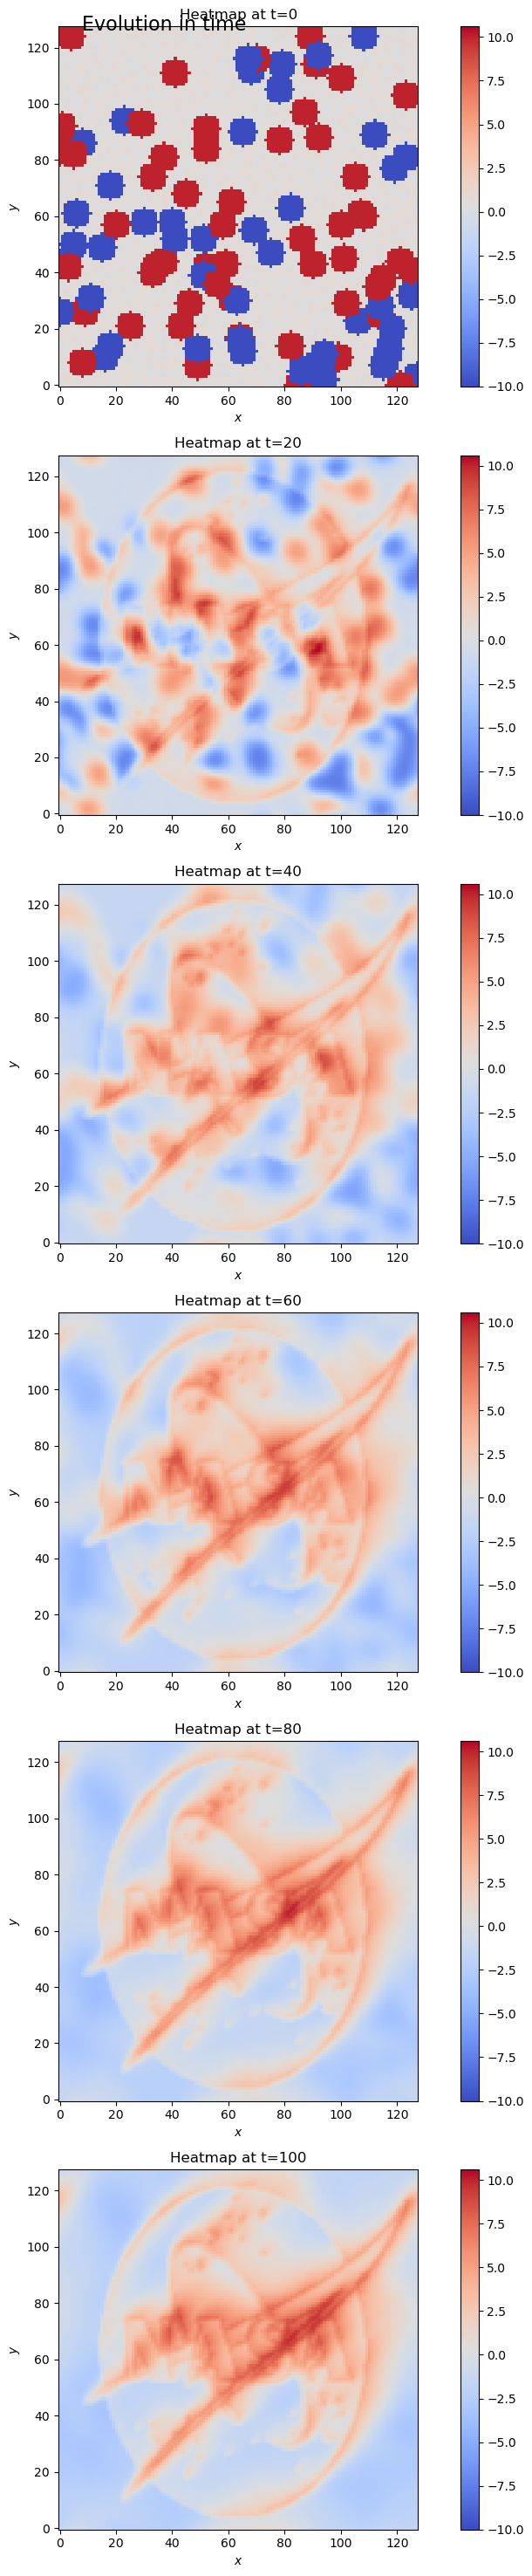

In [33]:
nr,nc = 128,128
c0 = np.random.rand(nr,nc)
c0 = add_random_circles(c0, 100, 5, [-10,10])
c0 = c0.reshape(nr*nc,1)  ##FLATTEN IS BAD DO NOT FLATTEN
#c0 = np.random.rand(nr*nc,1)
print("here")

KX   = 3 * np.ones((nr,nc+1))
KY   = 3 * np.ones((nr+1,nc))

DX_C = 1 * np.ones((nr,nc+1))
DY_C = 1 * np.ones((nr+1,nc))

DX_G = 1 * np.ones((nr+1,nc))
DY_G = 1 * np.ones((nr,nc+1))

VX   = 30 * np.ones((nr,nc+1))
VY   = 30 * np.ones((nr+1,nc))

RAC  = 1 * np.ones((nr,nc))


F = 0.02
f = np.where( helper.NASA_map == 0, -3, 20).reshape(nr*nc,1)




#F    = 0
#f    = 0*np.ones((nr*nc,1))

def set_top_bottom_edges_to_zero(matrix):
    result = matrix.copy()

    result[0, :] = 0
    result[-1, :] = 0
    
    return result

def set_left_right_edges_to_zero(matrix):
    result = matrix.copy()

    result[:, 0] = 0
    result[:, -1] = 0
    
    return result



#KX, KY = set_top_bottom_edges_to_zero(KX), set_top_bottom_edges_to_zero(KY)
#Do same for V
#VX, VY = set_top_bottom_edges_to_zero(VX), set_top_bottom_edges_to_zero(VY)
#VX, VY = set_left_right_edges_to_zero(VX), set_left_right_edges_to_zero(VY)

M = make_M_2d_diffusion_advection_forcing(nr = nr, nc = nc, dt = 0.01,
                                    KX = KX, KY = KY,
                                    DX_C = DX_C , DY_C = DY_C,
                                    DX_G = DX_G,  DY_G = DY_G,
                                    VX = VX, VY = VY,
                                    RAC = RAC, F = F,
                                    cyclic_east_west = True, cyclic_north_south = True)
#print(M)

num_snapshot = 6
snapshots = np.array([i*20 for i in range(num_snapshot)])
duration = np.max(snapshots) + 1

saved_data = np.array(compute_2d_affine_time_evolution(c0, M, F*f, snapshots, duration))
disp_2d_time_evolution(saved_data, snapshots, nr, nc)

